## Problem 1: Visualise data in an interactive map (10 points)


Create an *interactive* **thematic map** using the skills you learnt during lesson 5. You can use *Folium*,<br>
or any other suitable Python package - feel free to experiment).

The map should contain more than one layer (from at least two different data sets). Pay attention to <br>
classification and visualisation (appropriate colour scheme choice, etc.). Write your code in this <br>
notebook, and store the resulting maps in `.html` format (plus possibly additional files, depending on<br>
your approach) in the `NOTEBOOK_DIRECTORY / "docs"` folder.

### Topic of the map

- Use any of the data sets we have used during the course (travel time data, population grid), or <br>
  any other data set of your interest (for example, [open data sets from Statistics Finland](https://www.stat.fi/org/avoindata/index_en.html), <br>
  or the open geo-data from [the Helsinki Region Infoshare](https://hri.fi/en)). If you download <br>
  data sets, add, commit, and push them to the `DATA_DIRECTORY`. Be sure to include an attribution <br>
  to each data set in your output map!
- Feel free to start from and adapt examples from the course material! You can take one step further <br>
  and add additional analysis to, e.g., the shopping centre dominance or the population within vincinity <br>
  of certain addresses)
- This should **not** be an interactive version of your submission for *problem 1*! Create something new!

### Criteria

- The map has more than one data layer (for instance, the results of an analysis, and the road network <br>
  to illustrate a complex spatial pattern). If (and only if) you think it adds additional value, feel <br>
  free to add a base map (but a base map does not count as an own layer) (2 points)
- The map portrays the output of an analysis or a classification that adds value beyond just displaying <br>
  the raw data (2 points)
- The map follows good cartographic practices (appropriate map extent and zoom level, colour scheme, <br>
  legend and data sources, etc.) (3 points)
- The map demonstrates the skills learnt during lesson 5, such as interactive elements (popups, etc.). (3 points)

### Output

- Save the map(s) in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder, remember to add, commit, <br>
  and push them to the GitHub repository
- Remember to also add, commit, and push input data sets and code

---

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [2]:
#get data
import geopandas
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import requests
import warnings
warnings.filterwarnings("ignore")

def get_wfs_data(data, filename):
    """
    Download data from a WFS service and save it to a file.
    """
    url = (
        f'https://kartta.hel.fi/ws/geoserver/avoindata/wfs'
        f'?service=wfs'
        f'&version=2.0.0'
        f'&request=GetFeature'
        f'&srsName=EPSG:3879'
        f'&typeName={data}'
        f'&outputFormat=GML2'
    )

    response = requests.get(url)
    save_path = DATA_DIRECTORY / filename
    with open(save_path, 'wb') as f:
        f.write(response.content)

get_wfs_data('avoindata:Seutukartta_liikenne_metro_rata', 'metro_track.gml')
get_wfs_data('avoindata:Seutukartta_liikenne_metroasemat', 'metro_stations.gml')
get_wfs_data('avoindata:Seutukartta_maankaytto_viheralueet', 'green_areas.gml')


In [3]:
# modify data
grid = geopandas.read_file(DATA_DIRECTORY / 'grid_data.gml')
helsinki_espoo_grid = grid[grid['nimi'].isin(['Helsinki', 'Espoo'])]
helsinki_espoo_grid.crs = 'EPSG:3879'

metro_track = geopandas.read_file(DATA_DIRECTORY / 'metro_track.gml')
metro_track.crs = 'EPSG:3879'

metro_stations = geopandas.read_file(DATA_DIRECTORY / 'metro_stations.gml')
metro_stations.crs = 'EPSG:3879'

green_areas = geopandas.read_file(DATA_DIRECTORY / 'green_areas.gml')
green_areas.crs = 'EPSG:3879'


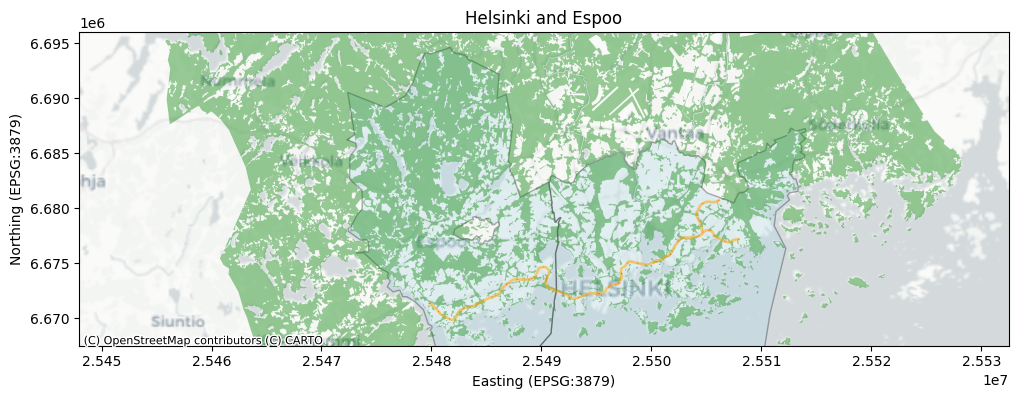

In [5]:
#plot data
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(12, 12))
#output_file = OUTPUT_DIRECTORY / 'metro_map.html'

helsinki_espoo_grid.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.3, linewidth=1)
metro_track.plot(ax=ax, color='orange', alpha=0.5, linewidth=2)
metro_stations.plot(ax=ax, color='red', markersize=20, alpha=0.9)
green_areas.plot(ax=ax, color='green', alpha=0.4)
ctx.add_basemap(ax, crs=helsinki_espoo_grid.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# Set title and labels
ax.set_title('Helsinki and Espoo')
ax.set_xlabel('Easting (EPSG:3879)')
ax.set_ylabel('Northing (EPSG:3879)')
ax.set_ylim(6667500, 6696000) 

#plt.savefig(output_file, format='png', dpi=300)
plt.show()



In [6]:
#interactive map
import folium
from shapely.geometry import Point

# get distances
def calculate_nearest_distance(stations, green_areas):
    """Calculate and retun distance from metro stations to nearest green area"""
    distances = []
    for idx, station in stations.iterrows():
        min_distance = green_areas.distance(station.geometry).min()
        distances.append(min_distance)
    return distances

metro_stations['distance_to_green'] = calculate_nearest_distance(metro_stations, green_areas)
metro_stations['distance_to_green_km'] = metro_stations['distance_to_green'] / 1000

# reproject to EPSG:4326
metro_stations = metro_stations.to_crs(epsg=4326)
green_areas = green_areas.to_crs(epsg=4326)
metro_track = metro_track.to_crs(epsg=4326)

m = folium.Map(location=[60.1695, 24.9354], zoom_start=12)

# green areas
folium.GeoJson(green_areas, name='Green Areas', style_function=lambda x: {
    'fillColor': 'green', 'color': 'green', 'weight': 1, 'fillOpacity': 0.4
}).add_to(m)

# metro lines
folium.GeoJson(metro_track, name='Metro Lines', style_function=lambda x: {
    'color': 'blue', 'weight': 3
}).add_to(m)

# metro station markers, each interactive marker displays station name and distance to nearest green area
for idx, station in metro_stations.iterrows():
    centroid = station.geometry.centroid
    distance_km = station['distance_to_green'] / 1000 
    folium.Marker(
        location=[centroid.y, centroid.x],
        popup=f"Station: {station['metroasema']}<br>Distance to nearest green area: {distance_km:.2f} km",
        icon=folium.Icon(color='orange', icon='subway', prefix='fa')
    ).add_to(m)

folium.LayerControl().add_to(m)

# save the map
m.save(OUTPUT_DIRECTORY / 'metro_with_green_distance_map.html')
